Linear Regressions
=====
This notebook contains example code for performing linear regressions using a variety of different calculation methods. It allows the user to create synthetic data, add noise/errors, and dynamically visualize the regression results. 

# Setup

In [ ]:
# Import necessary libraries
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylr2 import regress2
from ipywidgets import FloatText, IntText, BoundedFloatText, VBox, HBox, interactive_output

# Set the default plotting style
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

In [9]:
# Define regression functions. These are also defined in atmos.utils.regression_utils, but I define them here to make the notebook standalone. 

def linear_model(params, x):
    """Basic linear model.

    Args:
        params (list): List of parameters [slope, intercept].
        x (array-like): Independent variable.

    Returns:
        array: Dependent variable.
    """
    
    # Unpack parameters
    slope, yint = params
    return slope * x + yint


def york(xi, yi, dxi, dyi, ri=0.0, b0=1.0, maxIter=1e6):
    """Make a linear bivariate fit to xi, yi data using York et al. (2004).
    This is an implementation of the line fitting algorithm presented in:
    York, D et al., Unified equations for the slope, intercept, and standard
    errors of the best straight line, American Journal of Physics, 2004, 72,
    3, 367-375, doi = 10.1119/1.1632486
    See especially Section III and Table I. The enumerated steps below are
    citations to Section III
    Parameters:
      xi, yi      x and y data points
      dxi, dyi    errors for the data points xi, yi
      ri          correlation coefficient for the weights
      b0          initial guess b
      maxIter     float, maximum allowed number of iterations
    Returns:
      a           y-intercept, y = a + bx
      b           slope
      S           goodness-of-fit estimate
      sigma_a     standard error of a
      sigma_b     standard error of b
    Usage:
    [a, b] = bivariate_fit( xi, yi, dxi, dyi, ri, b0, maxIter)

    https://gist.github.com/mikkopitkanen/ce9cd22645a9e93b6ca48ba32a3c85d0
    """
    # (1) Choose an approximate initial value of b
    b = b0

    # (2) Determine the weights wxi, wyi, for each point.
    wxi = 1.0 / dxi**2.0
    wyi = 1.0 / dyi**2.0

    alphai = (wxi * wyi)**0.5
    b_diff = 999.0

    # tolerance for the fit, when b changes by less than tol for two
    # consecutive iterations, fit is considered found
    tol = 1.0e-8

    # iterate until b changes less than tol
    iIter = 1
    while (abs(b_diff) >= tol) & (iIter <= maxIter):

        b_prev = b

        # (3) Use these weights wxi, wyi to evaluate Wi for each point.
        Wi = (wxi * wyi) / (wxi + b**2.0 * wyi - 2.0*b*ri*alphai)

        # (4) Use the observed points (xi ,yi) and Wi to calculate x_bar and
        # y_bar, from which Ui and Vi , and hence betai can be evaluated for
        # each point
        x_bar = np.sum(Wi * xi) / np.sum(Wi)
        y_bar = np.sum(Wi * yi) / np.sum(Wi)

        Ui = xi - x_bar
        Vi = yi - y_bar

        betai = Wi * (Ui / wyi + b*Vi / wxi - (b*Ui + Vi) * ri / alphai)

        # (5) Use Wi, Ui, Vi, and betai to calculate an improved estimate of b
        b = np.sum(Wi * betai * Vi) / np.sum(Wi * betai * Ui)

        # (6) Use the new b and repeat steps (3), (4), and (5) until successive
        # estimates of b agree within some desired tolerance tol
        b_diff = b - b_prev

        iIter += 1

    # (7) From this final value of b, together with the final x_bar and y_bar,
    # calculate a from
    a = y_bar - b * x_bar

    # Goodness of fit
    S = np.sum(Wi * (yi - b*xi - a)**2.0)

    # (8) For each point (xi, yi), calculate the adjusted values xi_adj
    xi_adj = x_bar + betai

    # (9) Use xi_adj, together with Wi, to calculate xi_adj_bar and thence ui
    xi_adj_bar = np.sum(Wi * xi_adj) / np.sum(Wi)
    ui = xi_adj - xi_adj_bar

    # (10) From Wi , xi_adj_bar and ui, calculate sigma_b, and then sigma_a
    # (the standard uncertainties of the fitted parameters)
    sigma_b = np.sqrt(1.0 / np.sum(Wi * ui**2))
    sigma_a = np.sqrt(1.0 / np.sum(Wi) + xi_adj_bar**2 * sigma_b**2)

    # calculate covariance matrix of b and a (York et al., Section II)
    cov = -xi_adj_bar * sigma_b**2
    # [[var(b), cov], [cov, var(a)]]
    cov_matrix = np.array(
        [[sigma_b**2, cov], [cov, sigma_a**2]])

    if iIter <= maxIter:
        return a, b, S, cov_matrix, sigma_a, sigma_b
    else:
        print("bivariate_fit.py exceeded maximum number of iterations, " +
              "maxIter = {:}".format(maxIter))
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    

def get_R_squared(x,y,slope,intercept):
    """Calculate R-squared value.
    
    This function calculates the R-squared value for a linear regression model.
    The R-squared value indicates how well the independent variable explains the
    variability of the dependent variable. It is calculated as 1 minus the ratio
    of the residual sum of squares to the total sum of squares. 
    https://en.wikipedia.org/wiki/Coefficient_of_determination

    Args:
        x (array-like): Independent variable.
        y (array-like): Dependent variable.
        slope (float): Slope of the regression line.
        intercept (float): Intercept of the regression line.
        
    Returns:
        float: R-squared value.
    """
    y_pred = linear_model([slope,intercept],x)
    y_mean = np.mean(y)
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - y_mean)**2)
    r_squared = 1 - (ss_res/ss_tot)
    return r_squared

def get_r(x,y):
    """Calculate Pearson correlation coefficient (r).

    This function calculates the Pearson correlation coefficient (r) for a linear
    regression model. The Pearson correlation coefficient measures the strength
    and direction of the linear relationship between two variables. It is calculated
    as the covariance of the two variables divided by the product of their standard
    deviations. The value of r ranges from -1 to 1, where -1 indicates a perfect
    negative linear relationship, 1 indicates a perfect positive linear relationship,
    and 0 indicates no linear relationship.
    #https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

    Args:
        x (array-like): Independent variable.
        y (array-like): Dependent variable.

    Returns:
        float: Pearson correlation coefficient (r).
    """

    y_mean = np.mean(y)
    x_mean = np.mean(x)
    numerator = np.sum((x-x_mean)*(y-y_mean))
    denominator = np.sqrt(np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))
    return numerator/denominator

#Regressions
def ols_regression(df,x_name,y_name):
    """Perform Ordinary Least Squares (OLS) regression.

    This function performs Ordinary Least Squares (OLS) regression on the given
    DataFrame. It calculates the slope, intercept, R-squared value, Pearson correlation
    coefficient (r), p-value, and standard error of the regression line. 

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        x_name (str): Name of the independent variable column.
        y_name (str): Name of the dependent variable column.

    Returns:
        dict: Dictionary containing the regression results, including slope, intercept,
              R-squared value, Pearson correlation coefficient (r), p-value, and standard error.
    """

    working_df = df.copy() # Create a copy of the DataFrame to avoid modifying the original data
    x = working_df[x_name]
    y = working_df[y_name]

    slope,intercept,r_value,p_value,std_err = scipy.stats.linregress(x,y) # Perform linear regression
    R_squared = get_R_squared(x,y,slope,intercept) # Calculate R-squared value
    r = get_r(x,y) # Calculate Pearson correlation coefficient (r)
    out_dict = {
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'r': r,
        'r_squared':r**2,
        'R_squared': R_squared,
        'p_value': p_value,
        'std_err': std_err
    }
    return out_dict


def odr_regression(df,x_name, y_name, x_err_name, y_err_name,model_kwargs = {},data_kwargs = {},odr_kwargs = {},run_kwargs={},out_keychange = {}):
    """Perform Orthogonal Distance Regression (ODR).

    This function performs Orthogonal Distance Regression (ODR) on the given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        x_name (str): Name of the independent variable column.
        y_name (str): Name of the dependent variable column.
        x_err_name (str): Name of the error column for the independent variable.
        y_err_name (str): Name of the error column for the dependent variable.
        model_kwargs (dict): Additional keyword arguments for the ODR model.
        data_kwargs (dict): Additional keyword arguments for the ODR data.
        odr_kwargs (dict): Additional keyword arguments for the ODR instance.
        run_kwargs (dict): Additional keyword arguments for the ODR run.
        out_keychange (dict): Dictionary to change output keys.

    Returns:
        dict: Dictionary containing the regression results, including slope, intercept,
              standard deviations of slope and intercept, Pearson correlation coefficient (r),
              R-squared value, and other ODR output attributes.
    """
    working_df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original data

    # Extract the relevant columns from the DataFrame
    x = working_df[x_name]
    x_err = working_df[x_err_name]
    y = working_df[y_name]
    y_err = working_df[y_err_name]

    model = scipy.odr.Model(linear_model,**model_kwargs) # Create an ODR model with the linear model function and additional keyword arguments
    data = scipy.odr.RealData(x,y,x_err,y_err,**data_kwargs) # Create RealData object with the independent and dependent variables, including their errors
    myodr = scipy.odr.ODR(data,model,**odr_kwargs) # Create an ODR instance with the data and model, including additional keyword arguments

    myoutput = myodr.run(**run_kwargs) # Run the ODR instance to perform the regression 
    myoutput_dict = myoutput.__dict__ # Convert the output to a dictionary for easier access
   
    out_dict = {
        'slope': myoutput_dict['beta'][0],
        'intercept': myoutput_dict['beta'][1],
        'sd_slope': myoutput_dict['sd_beta'][0],
        'sd_intercept': myoutput_dict['sd_beta'][1],
    } # Extract slope and intercept from the output dictionary
    R_squared = get_R_squared(x,y,out_dict['slope'],out_dict['intercept']) # Calculate R-squared value
    r = get_r(x,y) # Calculate Pearson correlation coefficient (r)
    out_dict['r'] = r # Add Pearson correlation coefficient (r) to the output dictionary
    out_dict['r_squared'] = r**2 # Add r-squared value to the output dictionary
    out_dict['R_squared'] = R_squared # Add R-squared value to the output dictionary
    for key, value in myoutput_dict.items(): # Change the keys in the output dictionary based on the out_keychange mapping
        if key not in out_keychange.keys():
            out_dict[key] = value 
        else:
            out_dict[out_keychange[key]] = value
            
    return out_dict

def york_regression(df,x_name, y_name, x_err_name, y_err_name, york_kwargs = {}):
    """Perform York regression.

    This function performs York regression on the given DataFrame. York regression is a method for fitting a linear model to data with 
    errors in both the x and y directions.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        x_name (str): Name of the independent variable column.
        y_name (str): Name of the dependent variable column.
        x_err_name (str): Name of the error column for the independent variable.
        y_err_name (str): Name of the error column for the dependent variable.
        york_kwargs (dict): Additional keyword arguments for the York regression.

    Returns:
        dict: Dictionary containing the regression results, including slope, intercept,
              R-squared value, Pearson correlation coefficient (r), standard errors of slope and intercept,
              goodness-of-fit estimate (S), covariance matrix, and other York regression output attributes.
    
    """

    working_df = df.copy() # Create a copy of the DataFrame to avoid modifying the original data
    
    # Extract the relevant columns from the DataFrame
    x = working_df[x_name]
    x_err = working_df[x_err_name]
    y = working_df[y_name]
    y_err = working_df[y_err_name]

    # Perform York regression using the york function
    intercept, slope, S, cov, se_intercept, se_slope = york(x,y,x_err,y_err,**york_kwargs)

    R_squared = get_R_squared(x,y,slope,intercept) # Calculate R-squared value
    r = get_r(x,y) # Calculate Pearson correlation coefficient (r)

    # Create the output dictionary with regression results
    out_dict = {
        'slope': slope,
        'intercept': intercept,
        'r': r,
        'r_squared': r**2,
        'R_squared': R_squared,
        'S': S,
        'cov': cov,
        'se_slope': se_slope,
        'se_intercept': se_intercept
    }
    return out_dict

def rma_regression(df,x_name,y_name):
    """Perform Reduced Major Axis (RMA) regression.

    This function performs Reduced Major Axis (RMA) regression on the given DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data.
        x_name (str): Name of the independent variable column.
        y_name (str): Name of the dependent variable column.

    Returns:
        dict: Dictionary containing the regression results, including slope, intercept,
              Pearson correlation coefficient (r), R-squared value, standard deviations of slope and intercept.
    """

    # Create a copy of the DataFrame to avoid modifying the original data
    working_df = df.copy()

    # Extract the relevant columns from the DataFrame
    x = working_df[x_name]
    y = working_df[y_name]

    # Perform Reduced Major Axis regression using the regress2 function from pylr2
    results = regress2(x,y,_method_type_2 = 'reduced major axis')
    
    R_squared = get_R_squared(x,y,results['slope'],results['intercept']) # Calculate R-squared value
    r = get_r(x,y) # Calculate Pearson correlation coefficient (r)

    # Create the output dictionary with regression results
    out_dict = {
        'slope': results['slope'],
        'intercept': results['intercept'],
        'r_value': results['r'],
        'r': r,
        'r_squared': r**2,
        'R_squared': R_squared,
        'sd_slope': results['std_slope'],
        'sd_intercept': results['std_intercept']
    }
    return out_dict

def calculate_all_regressions(df,x_name,y_name,err_tags):
    """Calculate all regression types for given x and y variables with error tags.

    This function calculates Ordinary Least Squares (OLS), Orthogonal Distance Regression (ODR),
    York regression, and Reduced Major Axis (RMA) regression for the specified x and y variables
    with the provided error tags. It returns a dictionary containing the regression outputs for each error tag.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        x_name (str): Name of the independent variable column.
        y_name (str): Name of the dependent variable column.
        err_tags (list): List of error tags to be used for the regression calculations.

    Returns:
        dict: Dictionary containing the regression outputs for each error tag, including details,
              OLS regression results, ODR regression results, York regression results, and RMA regression results.
    """ 
    # Initialize a dictionary to store all regression outputs
    all_regression_outputs = {}

    # Loop through each error tag and perform the regressions
    for err_tag in err_tags:
        x_err_name = f'{x_name.split("_")[0]}_{err_tag}'
        y_err_name = f'{y_name.split("_")[0]}_{err_tag}'

        regr_outs = {
            'details': {'x_name': x_name, 'y_name': y_name, 'x_err_name': x_err_name, 'y_err_name': y_err_name},
            'ols': ols_regression(df, x_name, y_name),
            'odr': odr_regression(df, x_name, y_name, x_err_name, y_err_name, odr_kwargs={'beta0': (0.007, 0)}, out_keychange={'res_var': 'chi_squared'}),
            'york': york_regression(df, x_name, y_name, x_err_name, y_err_name),
            'rma': rma_regression(df, x_name, y_name)
        }
        all_regression_outputs[err_tag] = regr_outs
        
    return all_regression_outputs

def create_noisy_linear_df(slope, yint, npoints, x_noise_scale, y_noise_scale, x_error, y_error, x_min, x_max):
    """Create a DataFrame with noisy linear data.

    Args:
        slope (float): Slope of the linear function.
        yint (float): Y-intercept of the linear function.
        npoints (int): Number of data points to generate.
        x_noise_scale (float): Standard deviation of noise added to x values.
        y_noise_scale (float): Standard deviation of noise added to y values.
        x_error (float or array-like): Error in x values -- this is different from noise and is used to represent uncertainty and can be specifically set as either a constant or an array of length npoints. 
        y_error (float or array-like): Error in y values -- this is different from noise and is used to represent uncertainty and can be specifically set as either a constant or an array of length npoints.
        x_min (float): Minimum value for x.
        x_max (float): Maximum value for x.

    Returns:
        pd.DataFrame: DataFrame containing the noisy linear data with columns for x, y, and their respective errors.
    """

    np.random.seed(0) # Set seed for reproducibility
    x_arr = np.linspace(x_min, x_max, int(npoints)) # Generate evenly spaced x values
    y_arr = slope * x_arr + yint # Calculate y values based on the linear function

    # Add noise to x and y values
    x_noise = np.random.normal(0, x_noise_scale, size=x_arr.shape) # Generate noise for x values
    y_noise = np.random.normal(0, y_noise_scale, size=y_arr.shape) # Generate noise for y values
    x_arr_noisy = x_arr + x_noise  # Add noise to x values
    y_arr_noisy = y_arr + y_noise # Add noise to y values

    # Handle x_error
    if np.isscalar(x_error):
        x_error_arr = np.full_like(x_arr, x_error, dtype=float)
    else:
        x_error_arr = np.asarray(x_error, dtype=float)
        if x_error_arr.shape != x_arr.shape:
            raise ValueError("x_error must be a scalar or an array of length npoints.")

    # Handle y_error
    if np.isscalar(y_error):
        y_error_arr = np.full_like(y_arr, y_error, dtype=float)
    else:
        y_error_arr = np.asarray(y_error, dtype=float)
        if y_error_arr.shape != y_arr.shape:
            raise ValueError("y_error must be a scalar or an array of length npoints.")

    # Create the dataframe
    df = pd.DataFrame({
        'x_noisy': x_arr_noisy,
        'y_noisy': y_arr_noisy,
        'x_error': x_error,
        'y_error': y_error
    })

    return df

In [10]:
# Define plotting functions

def add_single_regression(ax,df,x_name,y_name,regression_output,
                           x_err_name = None, y_err_name = None,
                           summary_keys = None,scatter_kwargs = {'s':5,'c':'k'},
                           errorbar_kwargs = {'fmt':'o','markersize':0,'c':'grey'},
                           regression_line_kwargs = {'c':'r'}):
    
    """Add a single regression line to a matplotlib axis.

    Args:
        ax (matplotlib.axes.Axes): The axis to which the regression line will be added.
        df (pd.DataFrame): DataFrame containing the data.
        x_name (str): Name of the independent variable column.
        y_name (str): Name of the dependent variable column.
        regression_output (dict): Dictionary containing the regression results, including slope and intercept.
        x_err_name (str, optional): Name of the error column for the independent variable.
        y_err_name (str, optional): Name of the error column for the dependent variable.
        summary_keys (list, optional): List of keys to include in the summary text.
        scatter_kwargs (dict, optional): Additional keyword arguments for the scatter plot.
        errorbar_kwargs (dict, optional): Additional keyword arguments for the error bars.
        regression_line_kwargs (dict, optional): Additional keyword arguments for the regression line.

    Returns:
        matplotlib.axes.Axes: The axis with the regression line added.
    """
    
    working_df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original data

    # Extract the relevant columns from the DataFrame
    x = working_df[x_name]
    y = working_df[y_name]
    x_err = working_df[x_err_name] if x_err_name else None
    y_err = working_df[y_err_name] if y_err_name else None

    # Create a line for the regression based on the slope and intercept
    x_line = np.array([x.min(), x.max()]) # Create a line for the x values based on the min and max of x
    y_line = linear_model([regression_output['slope'], regression_output['intercept']], x_line) # Calculate the corresponding y values for the regression line

    if x_err is not None and y_err is not None: # If errors are provided
        ax.errorbar(x,y,xerr=x_err,yerr=y_err,**errorbar_kwargs)  # Add error bars to the scatter plot with the specified keyword arguments

    ax.scatter(x,y,**scatter_kwargs) # Add scatter plot of the data points with the specified keyword arguments
    ax.plot(x_line,y_line,c='r') # Plot the regression line in red

    if summary_keys:
        summary_text = '\n'.join([f"{key}: {format(regression_output[key], f'.{3}e')}" for key in summary_keys])
        ax.plot([],[],label=summary_text,**regression_line_kwargs)  # Add a label with the summary text to the plot, using the regression line color and style
    
    ax.legend() # Add a legend to the plot
    ax.set_xlabel(x_name) # Set the x-axis label
    ax.set_ylabel(y_name) # Set the y-axis label

    return ax

def plot_regressions(df, x_name, y_name, err_tags):
    """
    Plot multiple regression types for given x and y variables with error tags.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        x_name (str): Name of the independent variable column.
        y_name (str): Name of the dependent variable column.
        err_tags (list): List of error tags to be used for the regression calculations.

    Returns:
        None: Displays the plot with multiple regression types for each error tag.
    """

    # Calculate regression outputs for all error tags using the provided function
    all_regression_outputs = calculate_all_regressions(df, x_name, y_name, err_tags)

    # List of regression types to plot
    regression_types = ['ols', 'odr', 'york', 'rma']

    # Dictionary mapping regression types to the summary keys to display
    summary_key_dict = {
        'ols': ['slope', 'intercept', 'r_squared'],
        'odr': ['slope', 'intercept', 'r_squared', 'chi_squared', 'sd_slope', 'sd_intercept'],
        'york': ['slope', 'intercept', 'r_squared', 'S', 'se_slope', 'se_intercept'],
        'rma': ['slope', 'intercept', 'r_squared', 'sd_slope', 'sd_intercept']
    }

    # Number of error tags and regression types (for subplot grid)
    n_err = len(err_tags)
    n_reg = len(regression_types)

    # Create a grid of subplots: one row per error tag, one column per regression type
    fig, axs = plt.subplots(n_err, n_reg, figsize=(6 * n_reg, 5 * n_err), squeeze=False)

    # Loop over each error tag (row)
    for i, err_tag in enumerate(err_tags):
        regr_dict = all_regression_outputs[err_tag]

        # Extract error column names for this error tag from the regression output details
        x_err_name = regr_dict['details']['x_err_name']
        y_err_name = regr_dict['details']['y_err_name']

        # Loop over each regression type (column)
        for j, key in enumerate(regression_types):
            if key in regr_dict:
                # Plot the regression results using the provided plotting function
                add_single_regression(
                    axs[i, j], df, x_name, y_name, regr_dict[key],
                    x_err_name, y_err_name, summary_keys=summary_key_dict[key]
                )
                # Set the subplot title to indicate regression type and error tag
                axs[i, j].set_title(f"{key.upper()}")
            else:
                # Hide subplot if this regression type is not available
                axs[i, j].set_visible(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Display the plot
    plt.show()


def update_plots(slope, yint, npoints, x_noise_scale, y_noise_scale, x_error, y_error, x_min, x_max):
    """
    Generate noisy linear data and plot multiple regression types interactively.

    Args:
        slope (float): Slope of the linear function.
        yint (float): Y-intercept of the linear function.
        npoints (int): Number of data points to generate.
        x_noise_scale (float): Standard deviation of noise added to x values.
        y_noise_scale (float): Standard deviation of noise added to y values.
        x_error (float or array-like): Error in x values (scalar or array of length npoints).
        y_error (float or array-like): Error in y values (scalar or array of length npoints).
        x_min (float): Minimum value for x.
        x_max (float): Maximum value for x.

    Returns:
        None: Displays the regression plots interactively.
    """
    # Create a DataFrame with noisy linear data and associated errors
    df = create_noisy_linear_df(
        slope, yint, npoints, x_noise_scale, y_noise_scale, x_error, y_error, x_min, x_max
    )

    # Define column names for x and y data
    x_name = 'x_noisy'
    y_name = 'y_noisy'

    # Define error tags to be used for regression calculations
    # You can expand this list if you have multiple error tags (e.g., ['error', 'std', ...])
    err_tags = ['error']

    # Call the plotting function to display regression results for all error tags
    plot_regressions(df, x_name, y_name, err_tags)



# Basic visualization of a regression on synthetic data

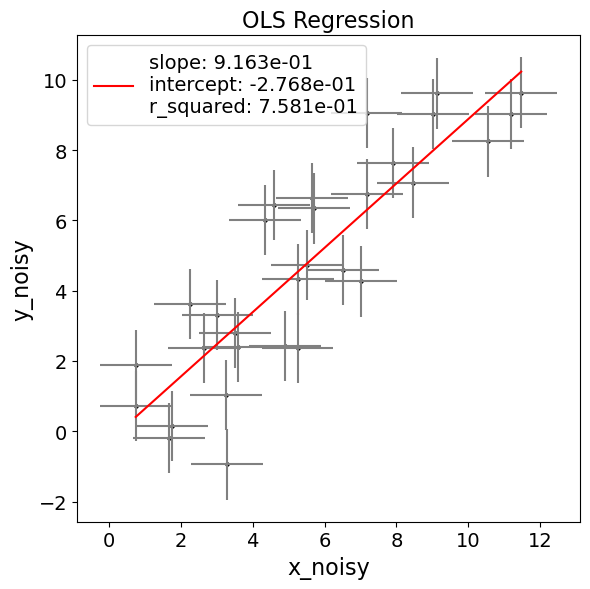

In [26]:
# --- Parameters ---
slope = 1.0
yint = 0.0
npoints = 30
x_noise_scale = 1.0
y_noise_scale = 1.0
x_error = 1.0
y_error = 1.0
x_min = 0.0
x_max = 10.0

# --- Data Generation ---
df = create_noisy_linear_df(
    slope, yint, npoints, x_noise_scale, y_noise_scale, x_error, y_error, x_min, x_max
)

x_name = 'x_noisy'
y_name = 'y_noisy'
x_err_name = 'x_error'
y_err_name = 'y_error'
err_tags = ['error']

# --- Run all regressions using your function ---
all_regression_outputs = calculate_all_regressions(df, x_name, y_name, err_tags)

# --- Choose which regression to plot (e.g., OLS) ---
regression_type = 'ols'  # Change to 'odr', 'york', or 'rma' as desired
regression_output = all_regression_outputs['error'][regression_type]

# --- Plotting using your add_single_regression function ---
fig, ax = plt.subplots(figsize=(6, 6))
add_single_regression(
    ax, df, x_name, y_name, regression_output,
    x_err_name=x_err_name, y_err_name=y_err_name,
    summary_keys=['slope', 'intercept', 'r_squared']
)
ax.set_title(f"{regression_type.upper()} Regression", fontsize=16)
plt.tight_layout()
plt.show()

# Interactive visualization of multiple regression models on synthetic data, changing parameters dynamically

In [27]:
# Set up interactive text boxes for all parameters
slope_box = FloatText(value=1.0, description='Slope')
yint_box = FloatText(value=0.0, description='Yint')
npoints_box = IntText(value=10, description='NPoints')  # Only allows integers

x_noise_box = BoundedFloatText(value=1.0, min=0.0, description='X Noise')   # No negatives
y_noise_box = BoundedFloatText(value=1.0, min=0.0, description='Y Noise')   # No negatives
x_error_box = BoundedFloatText(value=1.0, min=0.0, description='X Error')   # No negatives
y_error_box = BoundedFloatText(value=1.0, min=0.0, description='Y Error')   # No negatives

x_min_box = FloatText(value=0.0, description='X Min')
x_max_box = FloatText(value=10.0, description='X Max')

# Create a box layout for the text boxes
column1 = VBox([slope_box, yint_box, npoints_box])
column2 = VBox([x_min_box, x_max_box])
column3 = VBox([x_noise_box, y_noise_box])
column4 = VBox([x_error_box, y_error_box])
widgets_box = HBox([column1, column2, column3, column4])

# Create an interactive output that updates the plots based on the text box values
interactive_plot = interactive_output(update_plots, {
    'slope': slope_box,
    'yint': yint_box,
    'npoints': npoints_box,
    'x_noise_scale': x_noise_box,
    'y_noise_scale': y_noise_box,
    'x_error': x_error_box,
    'y_error': y_error_box,
    'x_min': x_min_box,
    'x_max': x_max_box,
})

In [28]:
# Display the widgets and the interactive plot
display(widgets_box, interactive_plot)

Output()